# Noise variance experiment

In [44]:
import os 
import torch

def load_all_batches(path : str, max_num_batches : int=None) -> dict[str, torch.Tensor]:
    # during inference, the samples are saved as batches 
    # this function concatenates all batches into a single list
    
    # find all files on the form batch_*.pt
    files = [f for f in os.listdir(path) if f.startswith("batch_") and f.endswith(".pt")]
    files.sort()
    if max_num_batches is not None:
        files = files[:max_num_batches]
    x0s, x1s, x0_recons, trajectories = [], [], [], []
    for file in files:
        batch = torch.load(os.path.join(path, file), weights_only=True)
        x0s.append(batch["x0"])
        x1s.append(batch["x1"])
        x0_recons.append(batch["x0_recon"])
        trajectories.append(batch["trajectory"])
    # concatenate all batches into a single tensor
    x0 = torch.cat(x0s, dim=0)
    x1 = torch.cat(x1s, dim=0)
    x0_recon = torch.cat(x0_recons, dim=0)
    if trajectories[0] is not None:
        trajectories = torch.cat(trajectories, dim=1)
    return {
        "x0": x0,
        "x1": x1,
        "x0_recon": x0_recon,
        "trajectory": trajectories
    }


model_to_name = {
    'mel_sto': 'DSB Log Mel',
    'stft_sto': 'DSB STFT',
    'stft_det': 'DSB STFT',
    'gfb': 'GFB STFT',
    'baseline': 'Baseline',
}

model_to_color = {
    'mel_sto': '#4E79A7',
    'stft_sto': '#F28E2B',
    'stft_det': '#F28E2B',
    'gfb': '#E15759',
}

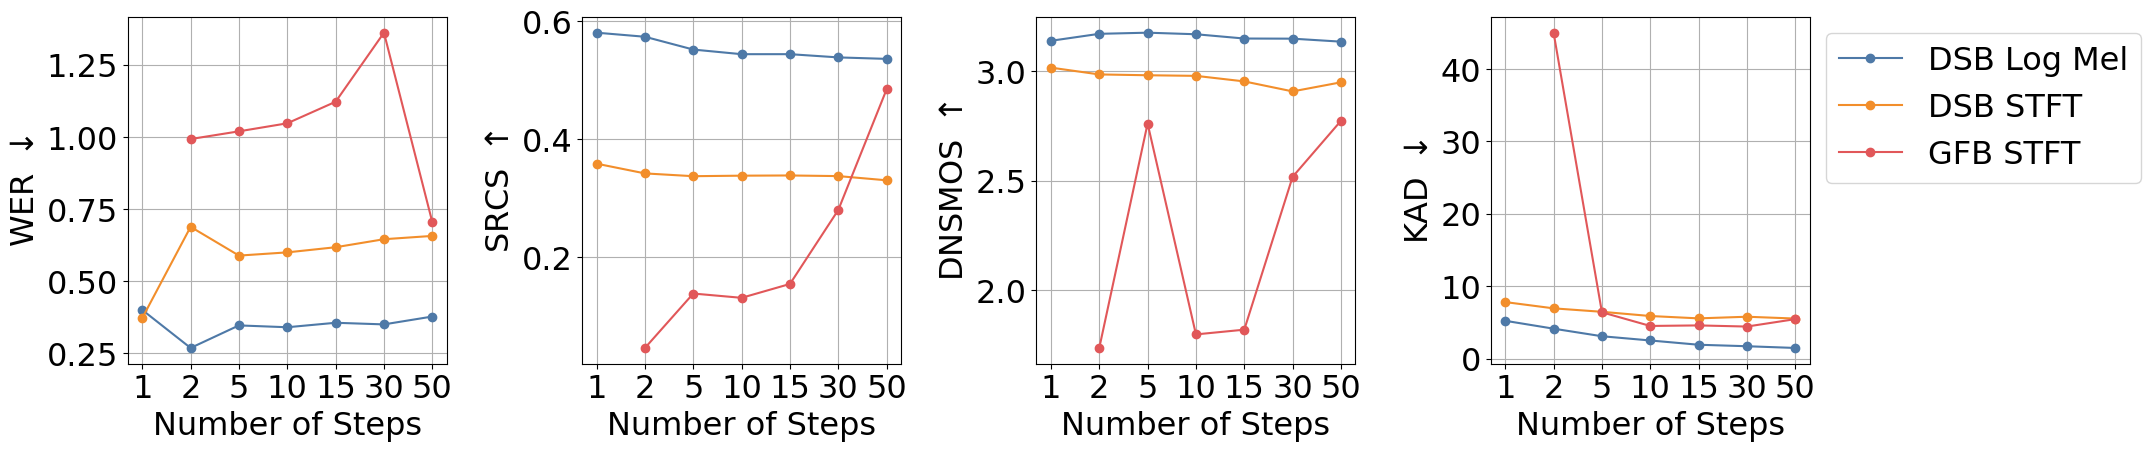

In [46]:
import matplotlib.pyplot as plt
import torch

data = dict()
what_test = "clip"

num_steps = [1, 2, 5, 10, 15, 30, 50]  # reversed order for plotting
for model in ['mel_sto', 'stft_sto', 'gfb', 'baseline']:
    data[model] = dict()
    for metric in ['wer', 'srcs', 'dnsmos', 'kad']:
        metric_dict = dict()
        for num_step in num_steps:
            if num_step == 1 and model == 'gfb':
                continue
            
            if model == 'baseline':
                path = f"test_results/test_{what_test}/baseline"
            else:
                path = f"test_results/test_{what_test}/{model}_{num_step}"
                
            metrics = torch.load(path + "/metrics.pt", weights_only=True)
            value = metrics[metric]
            value = torch.tensor(value)
            value = value.mean().item()
            
            metric_dict[num_step] = value
            
            if model == 'baseline':
                continue

        data[model][metric] = metric_dict

fig, axs = plt.subplots(1, 4, figsize=(22, 5))
axs : list[plt.Axes]
plt.rcParams.update({'font.size': 23})

for i, (model, metrics) in enumerate(data.items()):    
    if model == 'baseline':
        continue
    
    xvalues = range(len(num_steps)) if model != 'gfb' else range(1, len(num_steps))  # GFB does not have num_step=1
    axs[0].plot(xvalues, metrics['wer'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[1].plot(xvalues, metrics['srcs'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[2].plot(xvalues, metrics['dnsmos'].values(), marker='o', linestyle='-', color=model_to_color[model])
    axs[3].plot(xvalues, metrics['kad'].values(), marker='o', linestyle='-', color=model_to_color[model], label=model_to_name[model])
for i in range(4):
    axs[i].set_xlabel("Number of Steps")
    axs[i].set_ylabel([r"WER $\downarrow$", r"SRCS $\uparrow$", r"DNSMOS $\uparrow$", r"KAD $\downarrow$"][i])
    axs[i].grid(True)
    axs[i].set_xticks(range(len(num_steps)))
    axs[i].set_xticklabels(num_steps)
    if i == 3:
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"test_results/test_{what_test}/metrics.png", bbox_inches='tight', dpi=300)
plt.show()


In [47]:
# make it easy to copy paste the results to txt file
n_decimals = 2
for m in ['stft_sto', 'mel_sto', 'gfb', 'baseline']:
    if m == 'baseline':
        num_steps = [1]
    if m in ['stft_sto', 'mel_sto']:
        num_steps = [30, 1]
    if m == 'gfb':
        num_steps = [30, 2]
    
    for num_step in num_steps:
        if m == 'baseline':
            print(f"{model_to_name[m]} & {data[m]['dnsmos'][num_step]:.{n_decimals}f} & {data[m]['wer'][num_step]:.{n_decimals}f} & {data[m]['srcs'][num_step]:.{n_decimals}f} & {data[m]['kad'][num_step]:.{n_decimals}f} \\\\")
        else:
            print(f"{model_to_name[m]} ({num_step} step) & {data[m]['dnsmos'][num_step]:.{n_decimals}f} & {data[m]['wer'][num_step]:.{n_decimals}f} & {data[m]['srcs'][num_step]:.{n_decimals}f} & {data[m]['kad'][num_step]:.{n_decimals}f} \\\\")


DSB STFT (30 step) & 2.91 & 0.65 & 0.34 & 5.80 \\
DSB STFT (1 step) & 3.02 & 0.37 & 0.36 & 7.82 \\
DSB Log Mel (30 step) & 3.15 & 0.35 & 0.54 & 1.73 \\
DSB Log Mel (1 step) & 3.14 & 0.40 & 0.58 & 5.24 \\
GFB STFT (30 step) & 2.52 & 1.36 & 0.28 & 4.44 \\
GFB STFT (2 step) & 1.74 & 0.99 & 0.05 & 45.03 \\
Baseline & 2.58 & 0.11 & 0.47 & 5.92 \\


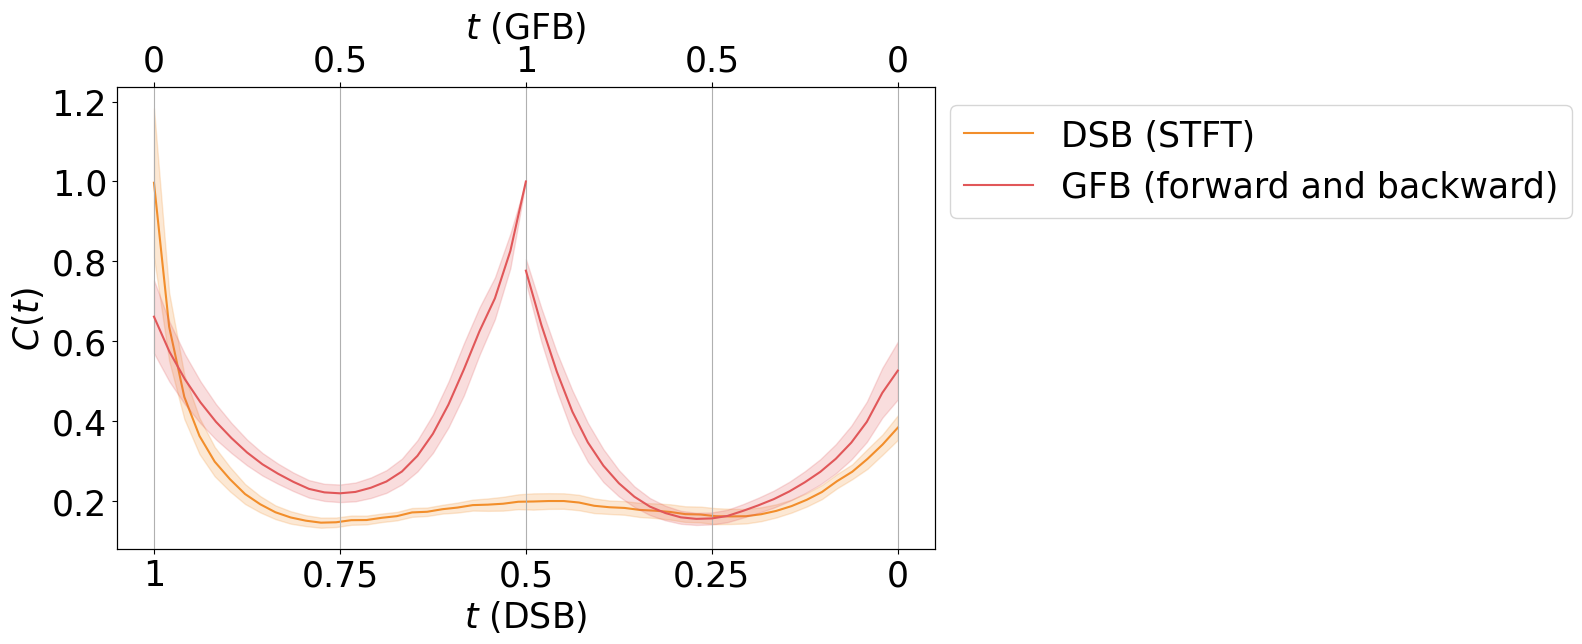

In [48]:
# investigate trajectory curvature

import torch
from src.callbacks.metrics import calculate_curvature_displacement
from torch import Tensor

def calculate_gfb_curvature_from_path(path : str, max_num_batches : int, direction : str) -> tuple[Tensor, Tensor]:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    timeschedule = torch.cat([torch.tensor([0.0]), timeschedule], dim=0)
    trajectories = batches['trajectory']
    forward_trajectory, backwrd_trajectory = trajectories.chunk(2, dim=0)
    
    if direction == 'forward':
        return calculate_curvature_displacement(forward_trajectory, timeschedule), timeschedule
    elif direction == 'backward':
        return calculate_curvature_displacement(backwrd_trajectory, timeschedule), timeschedule

def calculate_dsb_curvature_from_path(path : str, max_num_batches : int) -> Tensor:
    batches = load_all_batches(path, max_num_batches)
    params = torch.load(path + "/params.pt", weights_only=True)
    timeschedule = params['timeschedule']
    trajectories = batches['trajectory']
    return calculate_curvature_displacement(trajectories, timeschedule), timeschedule

models = ['gfb', 'stft_det']
num_steps = 30
data : dict[str, tuple[Tensor, Tensor]] = dict()
n_batches = 1

for model in models:
    data[model] = dict()

    path = f"test_results/test_traj/{model}"
    
    if model == 'gfb':
        cts_forward, timeschedule = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='forward')
        cts_backward, _ = calculate_gfb_curvature_from_path(path, max_num_batches=n_batches, direction='backward')
        data['gfb_forward'] = cts_forward, timeschedule
        data['gfb_backward'] = cts_backward, timeschedule
    else:
        cts, timeschedule = calculate_dsb_curvature_from_path(path, max_num_batches=n_batches)
        data['dsb'] = cts, timeschedule


import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(10, 7))

stft_traj = data['dsb'][0]
stft_traj = stft_traj.flip(dims=[1])
stft_mean = stft_traj.mean(dim=0)
stft_std = stft_traj.std(dim=0)
timeschedule = torch.linspace(0, 1, steps=stft_traj.shape[1])  # create a timeschedule from 0 to 1

ax.plot(timeschedule, stft_mean, label="DSB (STFT)", color=model_to_color['stft_det'])
ax.fill_between(timeschedule, stft_mean - stft_std, stft_mean + stft_std, alpha=0.2, color=model_to_color['stft_det'])

ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels([1, 0.75, 0.5, 0.25, 0])
ax.set_xlabel("$t$ (DSB)")

ax2 = ax.twiny()  # create a second y-axis

forward_traj = data['gfb_forward'][0]
backward_traj = data['gfb_backward'][0]
timeschedule = torch.linspace(0, 1, steps=forward_traj.shape[1])  # create a timeschedule from 0 to 1

forward_mean = forward_traj.mean(dim=0)
forward_std = forward_traj.std(dim=0)
backward_mean = backward_traj.mean(dim=0)
backward_std = backward_traj.std(dim=0)

ax2.plot(timeschedule, forward_mean, color=model_to_color['gfb'])
ax2.plot(timeschedule + 1, backward_mean, label="GFB (forward and backward)", color=model_to_color['gfb'])
ax2.fill_between(timeschedule, forward_mean - forward_std, forward_mean + forward_std, alpha=0.2, color=model_to_color['gfb'])
ax2.fill_between(timeschedule + 1, backward_mean - backward_std, backward_mean + backward_std, alpha=0.2, color=model_to_color['gfb'])

# right now, x-axis goes from 0 to 2
# make the ticks look like they go from 0 to 1 and back to 0
ax2.set_xticks([0, 0.5, 1, 1.5, 2])
ax2.set_xticklabels([0, 0.5, 1, 0.5, 0])

ax2.set_xlabel("$t$ (GFB)")

ax.set_ylabel("$C(t)$")
fig.legend(loc='upper right', bbox_to_anchor=(1.8, 1), bbox_transform=ax.transAxes)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"test_results/test_clip/curvature_{num_steps}.png", bbox_inches='tight', dpi=300)
plt.show()

In [49]:
import os
import torchaudio

path = "/work3/s214630/Latent-DSB/audio_samples/"
os.makedirs(path, exist_ok=True)
n_samples = 5

for experiment in ['clip', 'rir']:
    for model in ['baseline', 'mel_sto', 'stft_sto', 'gfb']:
        if model == 'baseline':
            samples_path = f"test_results/test_{experiment}/baseline"
            batches = load_all_batches(samples_path, max_num_batches=3)
            x0 = batches['x0']
            x1 = batches['x1']
            for i in range(n_samples):
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x0_{i}.wav"), x0[i].squeeze().unsqueeze(0), 16000)
                torchaudio.save(os.path.join(path, f"{experiment}_{model}_x1_{i}.wav"), x1[i].squeeze().unsqueeze(0), 16000)
            
        else:
            if model == 'gfb':
                num_steps = [30]
            else:
                num_steps = [30, 1]
            
            for num_step in num_steps:
                samples_path = f"test_results/test_{experiment}/{model}_{num_step}"
                batches = load_all_batches(samples_path, max_num_batches=1)
                x0_recon = batches['x0_recon']
                for i in range(n_samples):
                    torchaudio.save(os.path.join(path, f"{experiment}_{model}_{num_step}_x0_recon_{i}.wav"), x0_recon[i].squeeze().unsqueeze(0), 16000)
            